In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# Define exact colors for each category
colors = ["#FF0000", "#00FF00", "#0000FF"]
colors = ["blue", "red", "lightgrey"]
custom_cmap = ListedColormap(colors)
# Create a custom colormap: transparent to dark blue
colors = [(0, 0, 1, 0), (0.6, 0.6, 1, 1), (0.3, 0.3, 1, 1), (0, 0, 0.5, 1)]
transparent_blues = LinearSegmentedColormap.from_list("transparent_blues", colors, N=256)
colors = [
    (1, 0.9, 0.9, 0),   # light red, fully transparent
    (1, 0.5, 0.5, 0.4), # medium red, semi-transparent
    (0.8, 0.1, 0.1, 0.8), # darker red, more opaque
    (0.5, 0, 0, 1)      # dark red, fully opaque
]
transparent_reds = LinearSegmentedColormap.from_list("transparent_reds", colors, N=256)
colors = [
    (1, 1, 0.9, 0),    # very light yellow, fully transparent
    (1, 1, 0.6, 0.3),  # light yellow, semi-transparent
    (1, 0.9, 0.3, 0.6),# medium yellow, more opaque
    (0.8, 0.6, 0, 1)   # dark yellow, fully opaque
]
transparent_yellows = LinearSegmentedColormap.from_list("transparent_yellows", colors, N=256)
colors = [
    (0.9, 1.0, 0.9, 0),     # very light green, fully transparent
    (0.6, 0.8, 0.6, 0.5),   # light green, semi-transparent
    (0.3, 0.6, 0.3, 0.8),   # medium green, more opaque
    (0.0, 0.4, 0.0, 1)      # dark green, fully opaque
]
transparent_greens = LinearSegmentedColormap.from_list("transparent_greens", colors, N=256)
colors = [
    (1, 1, 1, 0),     # white/very light grey, fully transparent
    (0.7, 0.7, 0.7, 0.5),  # light grey, semi-transparent
    (0.4, 0.4, 0.4, 0.8),  # medium grey, more opaque
    (0.1, 0.1, 0.1, 1)     # dark grey, fully opaque
]
colors = [
    (1, 1, 1, 0),     # white/very light grey, fully transparent
    (0.4, 0.4, 0.4, 0.5),  # light grey, semi-transparent
    (0.2, 0.2, 0.2, 0.8),  # medium grey, more opaque
    (0.1, 0.1, 0.1, 1)     # dark grey, fully opaque
]
transparent_greys = LinearSegmentedColormap.from_list("transparent_greys", colors, N=64) #N=256)
cmaps = [transparent_greens, transparent_reds, transparent_greys]


def plot_results(axes, results_df, dataset, learner):

    labels = [2,1,0]
    # labels = [0]
    for label in labels:
        subset = results_df[results_df["label"] == label]
        if len(subset) == 0:
            continue
        axes.hexbin(subset["prediction_score"],
                    subset["assay_score"], gridsize=80, cmap=cmaps[label])
        # axes.colorbar(label='Density')
        # axes.scatter(subset["prediction_score"],
        #              subset["assay_score"],
        #              c=colors[label],
        #              alpha=0.8)
    axes.set_title(f'{dataset}/{learner}', fontsize=16)
    axes.set_ylabel('Assay Value', fontsize=14)
    axes.set_xlabel('Prediction', fontsize=14)
    # plt.colorbar(scatter, ax=axes, label="Label")



In [4]:
datasets = [
    "ADRB2",
    "AICDA",
    "BRCA1",
    "BRCA2",
    "CALM1",
    "CAR11",
    "CASP3",
    "CASP7",
    "CBS",
    "GDIA",
    "GRB2",
    "HEM3",
    "HMDH",
    "HXK4",
    "KCNE1",
    "KCNH2",
    "MET",
    "MK01",
    "MSH2",
    "MTHR",
    "NPC1",
    "OTC",
    "P53",
    "PAI1",
    "PPARG",
    "PPM1D",
    "PTEN",
    "RAF1",
    "RASH",
    "S22A1",
    "SC6A4",
    "SCN5A",
    "SERC",
    "SHOC2",
    "SRC",
    "SUMO1",
    "SYUA",
    "TADBP",
    "TPK1",
    "TPOR",
    "UBC9",
    "VKOR1",
    "brenan",
    "cas12f",
    "cov2_S",
    "doud",
    "giacomelli",
    "haddox",
    "jones",
    "kelsic",
    "lee",
    "markin",
    "stiffler",
    "zikv_E"]


In [7]:
import context  # noqa: F401
from msalde.container import ALDEContainer
from notebooks.analysis_plotter import (
    DATASETS
)

def get_clinvar_labels_for_dataset(repo, external_repo, dataset_name):
    gene_symbol = repo.get_gene_symbol_for_dataset(dataset_name)
    clinvar_labels = external_repo.get_clinvar_labels_by_gene(gene_symbol)
    return clinvar_labels

datasets = DATASETS
# datasets = ["cas12f2"]
container = ALDEContainer("./config/msaldem.yaml")
# container = ALDEContainer("./config/msalde.yaml")
repo = container.query_repository
external_repo = container.external_repository

datasets_ = datasets
#datasets_ = datasets
# datasets_ = ["cas12f2"]

def show_performance_correlations(join_method="left", require_clinvar_label=False):
    num_rows = len(datasets_)

    fig, axes = plt.subplots(num_rows*2, 2, figsize=(20, 6*len(datasets_)))
    axes = axes.flatten()
    ind = 0
    for dataset in datasets_:
        results = repo.get_last_round_scores_by_config_dataset_run(
            config_id="c3_1", dataset_name=dataset, run_name="RF_AL")
        if len(results) == 0:
            continue
        clinvar_labels = get_clinvar_labels_for_dataset(repo, external_repo, dataset)
        if require_clinvar_label and len(clinvar_labels) == 0:
            continue
        results = results.merge(clinvar_labels, on="variant_id", how=join_method)
        results["label"] = results["label"].fillna(2)
        plot_results(axes[ind], results, dataset, "RandomForest AL")
        ind += 1
        results = repo.get_last_round_scores_by_config_dataset_run(
            config_id="c3_2", dataset_name=dataset, run_name="RFTRAIN_ALL")
        results = results.merge(clinvar_labels, on="variant_id", how=join_method)
        results["label"] = results["label"].fillna(2)
        plot_results(axes[ind], results, dataset, "RandomForest Train20%")
        ind += 1
        results = repo.get_last_round_scores_by_config_dataset_run(
            config_id="c10", dataset_name=dataset, run_name="ESM2_LLR")
        results = results.merge(clinvar_labels, on="variant_id", how=join_method)
        results["label"] = results["label"].fillna(2)
        plot_results(axes[ind], results, dataset, "LogLikelihood")
        ind += 1
        results = repo.get_last_round_scores_by_config_dataset_run(
            config_id="c9_3", dataset_name=dataset, run_name="ESM2_HF")
        results = results.merge(clinvar_labels, on="variant_id", how=join_method)
        results["label"] = results["label"].fillna(2)
        plot_results(axes[ind], results, dataset, "HingeForest AL")
        ind += 1

    for j in range(ind, len(axes)):
        fig.delaxes(axes[j])
        
    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(hspace=0.5)
    plt.show()


In [ ]:
show_performance_correlations()

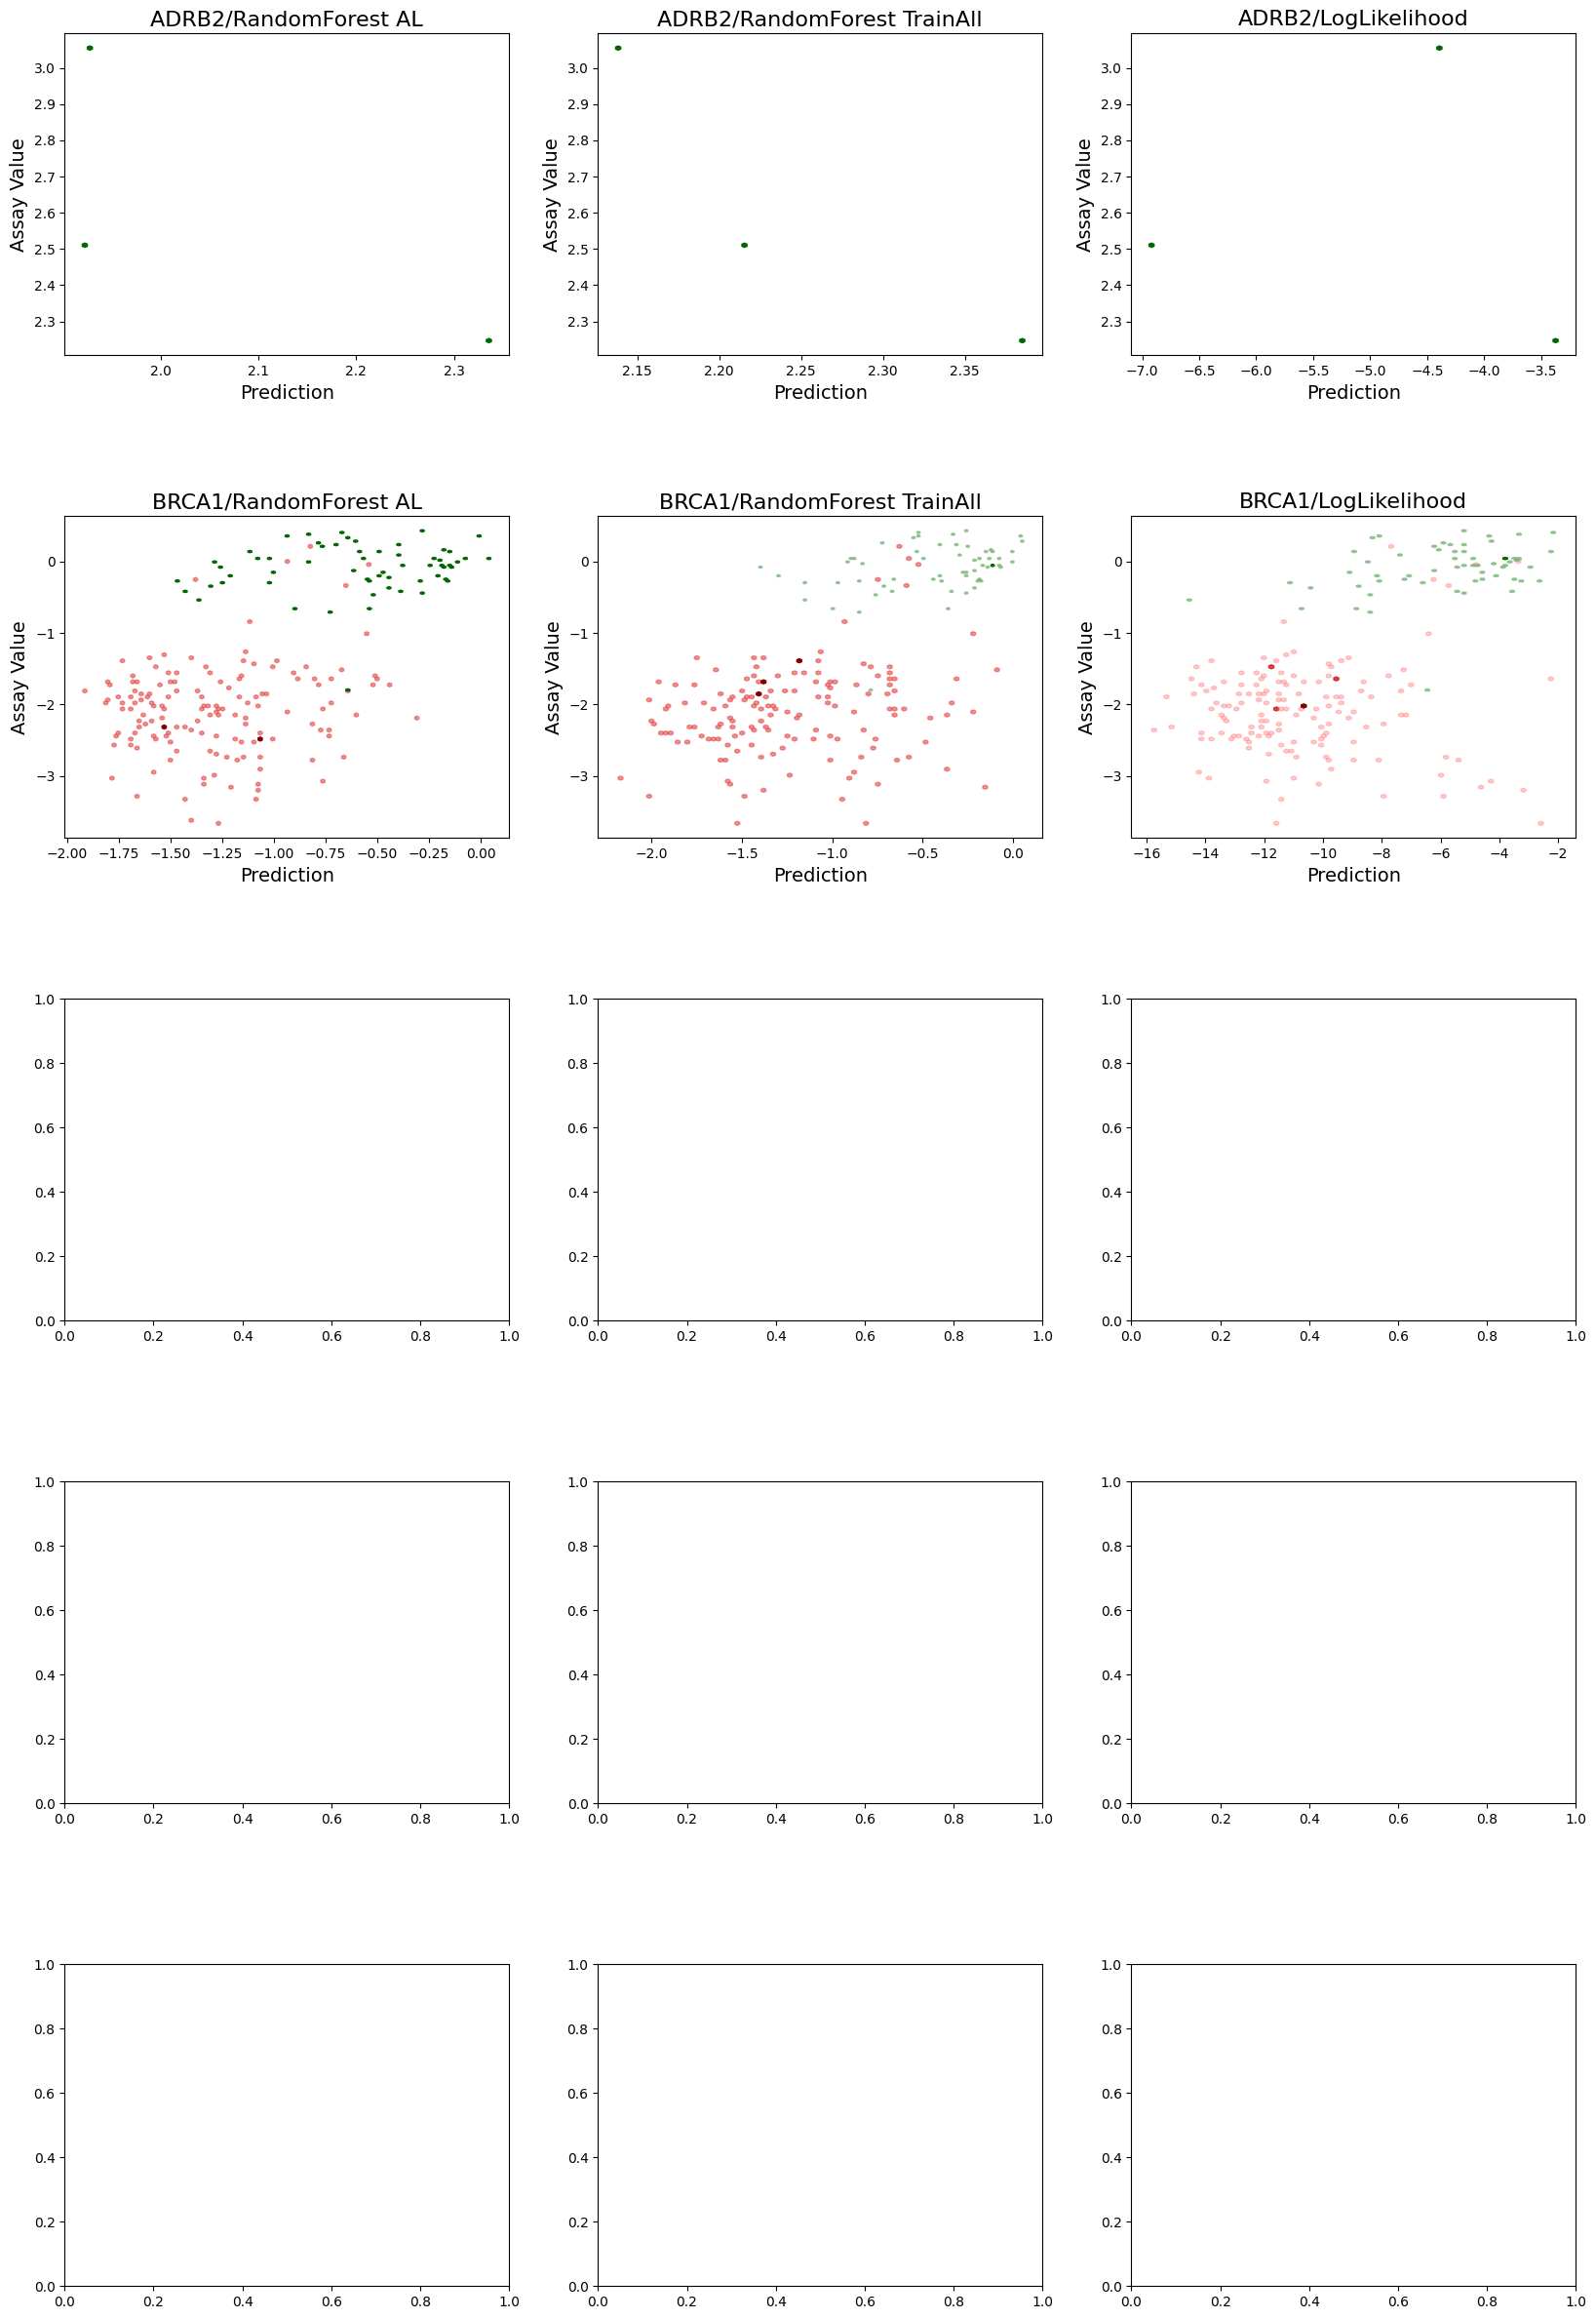

In [15]:
show_performance_correlations("inner", True)

/home/claudiof/gitrepo/msalde/venv_msalde/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/claudiof/gitrepo/msalde/notebooks/analysis_plotter.py:265: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


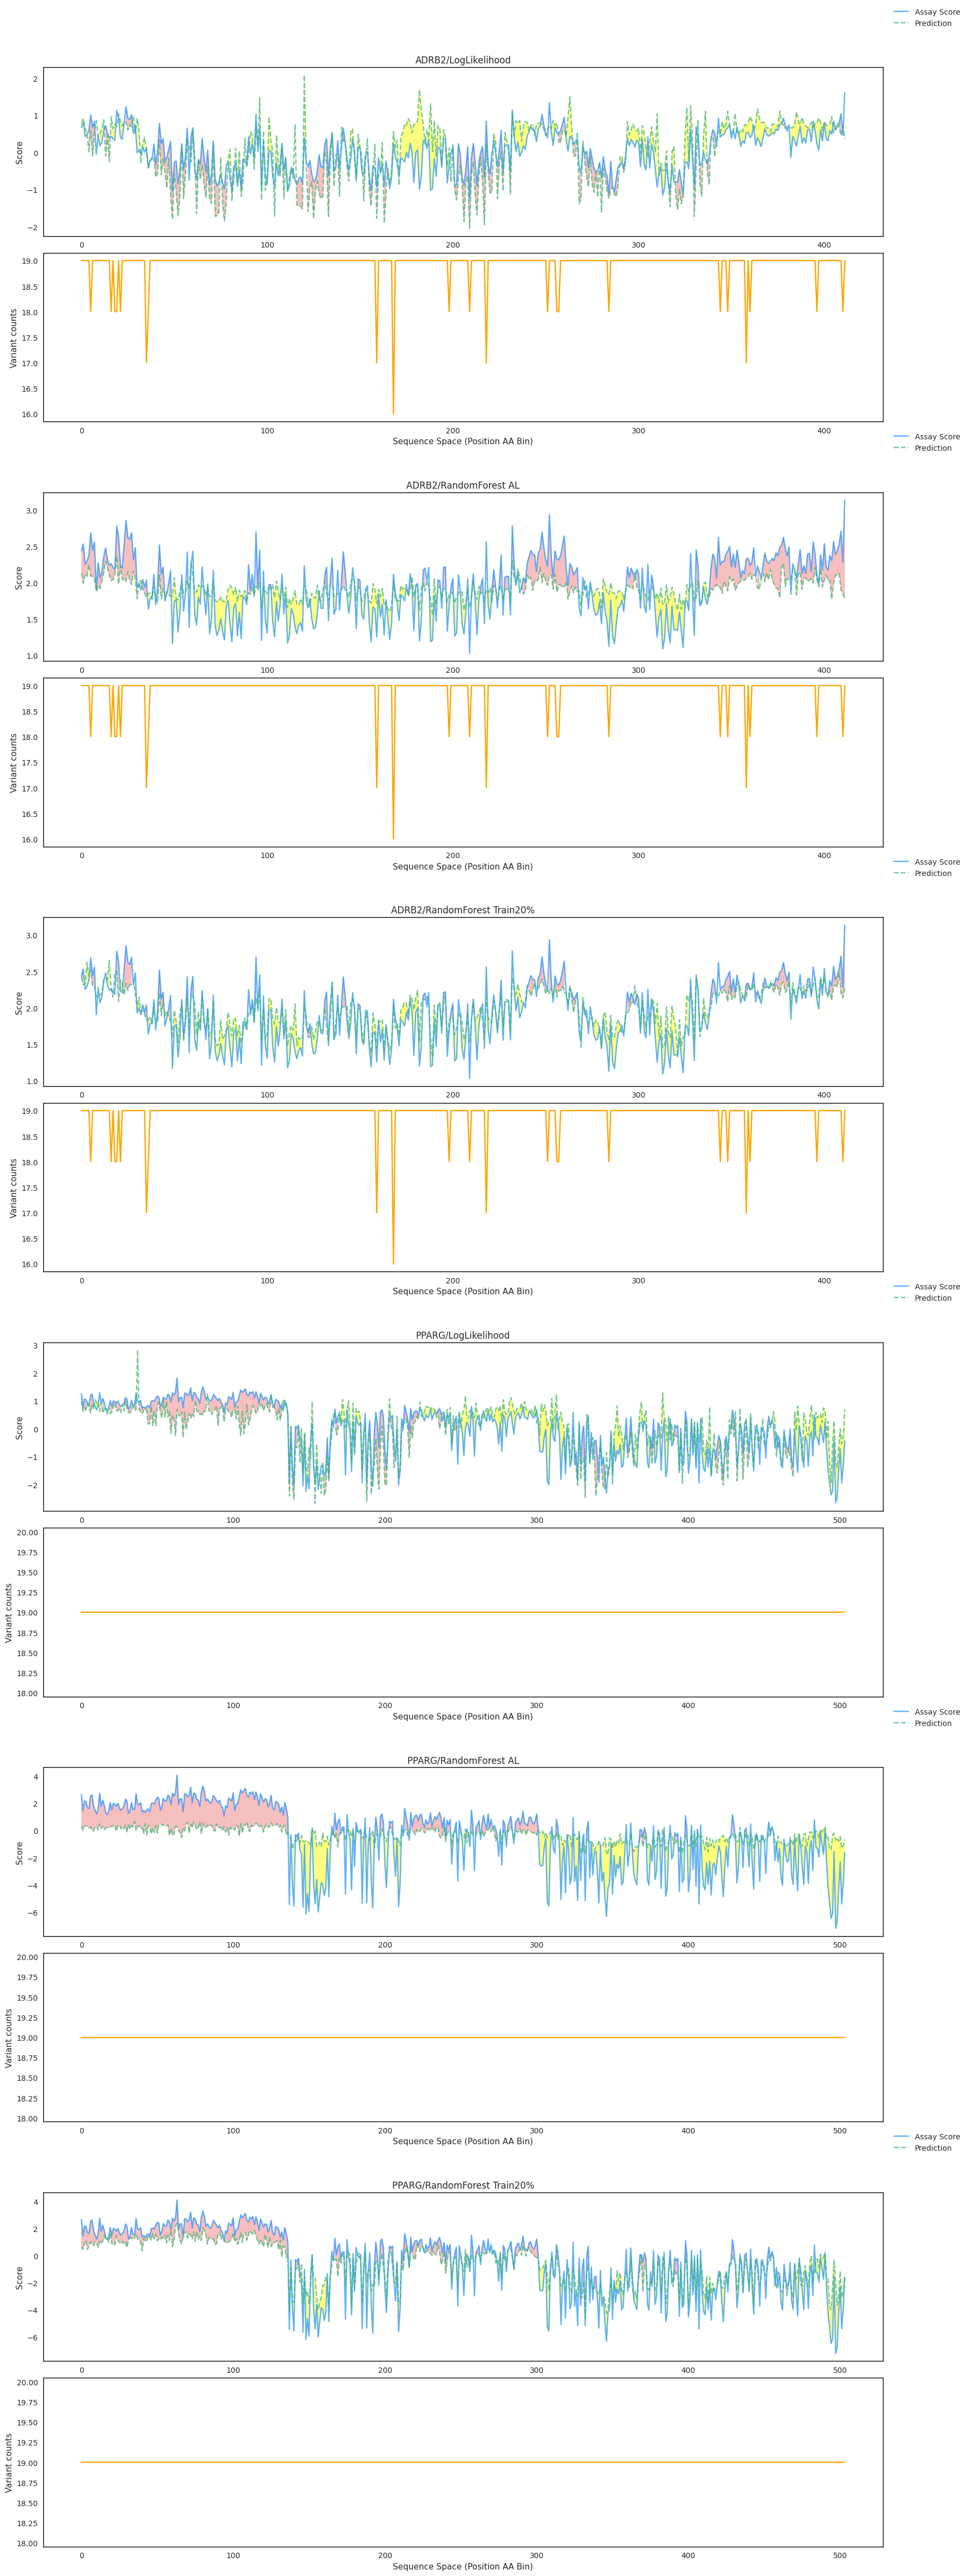

In [ ]:
import context  # noqa: F401
from notebooks.analysis_plotter import (
    show_protein_landscape_plots, show_protein_landscape_2d,
    show_protein_landscape_3d,
    DATASETS
)

datasets_ = DATASETS # [:3]
datasets_ = DATASETS[:3]
datasets_ = ["ADRB2", "PPARG", "SCN5A", "HXK4"]
show_protein_landscape_plots(show_protein_landscape_2d, datasets_)